# Keyword detection in a phrase - Sample code

In [1]:
import sounddevice as sd
import numpy as np
from python_speech_features import logfbank, delta, ssc, mfcc
import operator
import models
import matplotlib.pyplot as plt
from scipy.io import wavfile

Using TensorFlow backend.


### Different ways to input the audio
#### Recording from the microphone

In [ ]:
fs = 16000
seconds = 10

myrec = sd.rec(int(fs*seconds), samplerate=fs, channels=1)
sd.wait()

#### Reading it from a numpy array

In [2]:
fs = 16000
myrec = np.load("myrec.npy")

#### Reading it from a wav file

In [ ]:
fs, myrec = wavfile.read("fede2.wav")

#### Some information about it

Frequency sampling Fs = 16000 samples/s
Duration t = 10.0 s


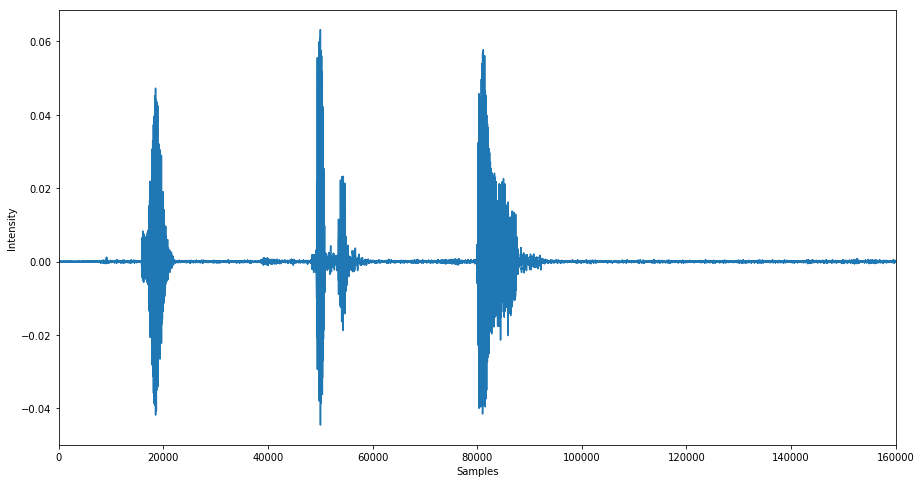

In [3]:
play = False

print("Frequency sampling Fs = " + str(fs) + " samples/s")
print("Duration t = " + str(len(myrec) / fs) + " s")

# Play it
if play:
    sd.play(myrec, fs)
    
# Plot
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(0, len(myrec))
plt.show()

### Settings and model initialization

In [4]:
feature = "filter_banks"
dataset = "1567874784415"

if feature == "filter_banks":
    input_size = (40, 98)
elif feature == "mfcc":
    input_size = (12, 98)
elif feature == "mfcc_deltas":
    input_size = (36, 98)
    
if dataset == "1567874784415":
    output_size = 31
elif dataset == "1567795202120":
    output_size = 5

classifier=models.CNNLSTMAttention(input_size, output_size, "radam")
classifier.load_weights("./results/" + dataset + "/Attention/" + feature + "/1/best_model_radam.h5")

Instructions for updating:
Colocations handled automatically by placer.


### Windowing
We now create windows of duration 1 second across all the signal and compute the wanted feature. Then, for every feature computed from the windows, we gave it as input to the network for the prediction 

In [8]:
offset = 400
frame_size = 16000
current_start = 0
i = 0
samples = []
range_samples = []

while (current_start + frame_size <= len(myrec)):
    i += 1
    #print(i, current_start, ";", (frame_size + current_start))
    samples.append(myrec[current_start:frame_size + current_start])
    range_samples.append((current_start, frame_size + current_start))
    current_start += offset
    
t = []
for s in samples:
    if feature == "filter_banks":
        fb = np.array(logfbank(s, fs, winlen=0.025, winstep=0.01, nfilt=40, nfft=400, preemph=0.97))
    elif feature == "mfcc":
        fb = np.array(mfcc(s, fs, winlen=0.025, winstep=0.01, nfilt=40, nfft=400, preemph=0.97, numcep=12, ceplifter=22))
    fb = fb[:-1, :].T
    fb -= (np.mean(fb, axis=0) + 1e-8)
    t.append(fb)
    
t = np.array(t)
t = t.reshape(-1,input_size[0], input_size[1] ,1)
print(t.shape)

p = classifier.predict(t)

words_name = ["bed", "bird", "cat", "dog", "down", "fight", "five", "four", "go", "happy",
             "house", "left", "marvin", "nine", "no", "off", "on", "one", "right", "seven",
             "sheila", "silence", "six", "stop", "three", "tree", "two", "up", "wow", "yes", "zero"]

output_frames = []
probabilties_frames = []

for pred in p:
    max_index = np.argmax(pred)
    prob = round((pred[max_index] * 100), 2)
    probabilties_frames.append(prob)
    if words_name[max_index] == "silence":
        #print("'" + words_name[max_index] + "' with probability " + str(prob) + "%")
        output_frames.append("-")
    else:
        if prob > 70:
            output_frames.append(words_name[max_index])
            #print("'" + words_name[max_index] + "' with probability " + str(prob) + "%")
        else:
            output_frames.append("-")
            

(361, 40, 98, 1)


In [9]:
keywords_samples = []
keywords_position = []
keywords_classification = []
k_d = {}
p_d = {}

count = 0
for i in range(len(output_frames)):
    if count == 0:
        if output_frames[i] != "-":
            initial_window = i
            count += 1
            k_d[output_frames[i]] = 1
            p_d[output_frames[i]] = probabilties_frames[i]
            
    else:
        if output_frames[i] != "-":
            count += 1
            if output_frames[i] in k_d:
                k_d[output_frames[i]] += 1
                p_d[output_frames[i]] = (p_d[output_frames[i]] + probabilties_frames[i]) / 2
            else:
                k_d[output_frames[i]] = 1
                p_d[output_frames[i]] = probabilties_frames[i]
        else:
            if count > 10:
                final_window = i
                #print ("Keyword from window " + str(range_samples[initial_window][0]) + " to " + str(range_samples[final_window][1]))
                keyword = myrec[range_samples[initial_window][0]: range_samples[final_window][1]]
                x = list(range(range_samples[initial_window][0], range_samples[final_window][1]))
                keywords_samples.append(keyword)
                keywords_position.append(x)
                mvk_c = max(k_d.items(), key=operator.itemgetter(1))[0]
                mvk_p = max(p_d.items(), key=operator.itemgetter(1))[0]
                if mvk_c == mvk_p:
                    keywords_classification.append(mvk_c)
                else:
                    if (p_d[mvk_p] - p_d[mvk_c]) > 4:
                        keywords_classification.append(mvk_c)
                    else:
                        keywords_classification.append(mvk_c + " or " + mvk_p)
                
                count = 0
                k_d = {}
                p_d = {}
            else:
                initial_window = i
                count = 0
                k_d = {}
                p_d = {}
                

### Final output

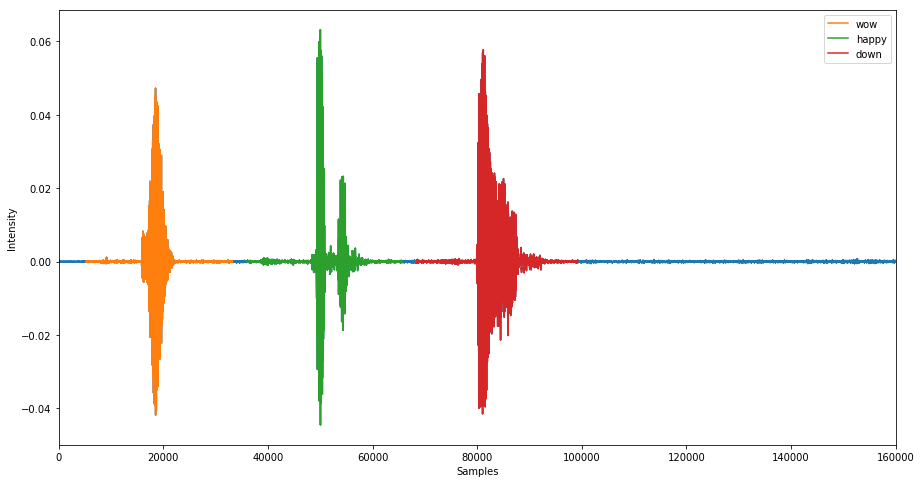

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(0, len(myrec))


for i in range(len(keywords_samples)):
    plt.plot(keywords_position[i], keywords_samples[i], label=keywords_classification[i])
    
plt.legend()
plt.show()